# *Ab* *initio* molecular dynamics of the vibrational motion of HF
We are going to construct what is often referred to as an *ab* *initio* potential energy surface of the diatomic
molecule hydrogen fluoride.  That is, we are going to use various electronic structure theories (Hartree-Fock theory (RHF), 2nd-order perturbation theory (MP2), and Coupled Cluster theory with single and double substitutions (CCSD)) to compute the electronic energy at different geometries of a simple diatomic molecule.  The same basis set (correlation consistent polarized triple-zeta, cc-pVTZ) will be used for all calculations.  We will use Psi4numpy to facilitate the electronic structure calculations, and then the interpolation capabilities of scipy to simplify the evalution of the potential energy at separations for which we did not explicitly evaluate the electronic energy.  We will also use scipy to differentiate the interpolated potential energy surface to obtain the forces acting on the atoms at different separations.  

We will start by importing the necessary libraries:

In [1]:
import numpy as np
import psi4
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

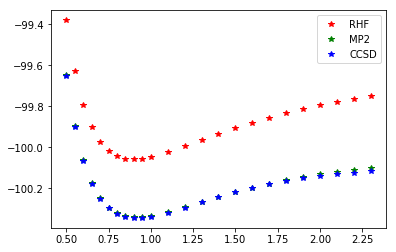

In [2]:
### template for the z-matrix
mol_tmpl = """H
F 1 **R**"""
### array of bond-lengths in anstromgs
r_array = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3])
### array for different instances of the HF molecule
molecules =[]
### array for the different RHF energies for different HF bond-lengths
HF_E_array = []
### array for the different MP2 energies for different HF bond-lengths
MP2_E_array = []
### array for the different CCSD energies for different HF bond-lengths
CCSD_E_array = []

### loop over the different bond-lengths, create different instances
### of HF molecule
for r in r_array:
    molecule = psi4.geometry(mol_tmpl.replace("**R**", str(r)))
    molecules.append(molecule)
    
### loop over instances of molecules, compute the RHF, MP2, and CCSD
### energies and store them in their respective arrays
for mol in molecules:
    energy = psi4.energy("SCF/cc-pVTZ", molecule=mol)
    HF_E_array.append(energy)
    energy = psi4.energy("MP2/cc-pVTZ", molecule=mol)
    MP2_E_array.append(energy)
    energy = psi4.energy("CCSD/cc-pVTZ",molecule=mol)
    CCSD_E_array.append(energy)

### Plot the 3 different PES
plt.plot(r_array,HF_E_array,'r*', label='RHF')
plt.plot(r_array,MP2_E_array,'g*', label='MP2')
plt.plot(r_array,CCSD_E_array,'b*', label='CCSD')
plt.legend()

Now that you have the raw data, we will interpolate this data using cubic splines.  This will permit us to 
estimate the potential energy at any arbitrary separation between 0.5 and 2.3 Angstroms (roughly 
1 and 4.3 a.u.) with fairly high confidence, and will also allow us to estimate the force 
(the negative of the derivative of the PES with respect to separation)
at any separation between 1.0 and 4.3 a.u. since the derivative of cubic splines are readily available.

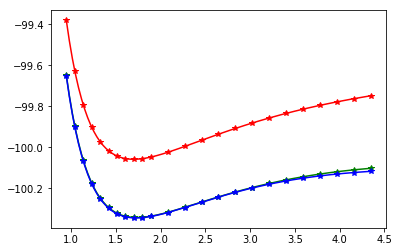

In [3]:
### use cubic spline interpolation
order = 3

### get separation vector in atomic units
r_array_au = 1.89*r_array 

### spline for RHF Energy
RHF_E_Spline = InterpolatedUnivariateSpline(r_array_au, HF_E_array, k=order)

### spline for MP2 Energy
MP2_E_Spline = InterpolatedUnivariateSpline(r_array_au, MP2_E_array, k=order)

### spline for CCSD Energy
CCSD_E_Spline = InterpolatedUnivariateSpline(r_array_au, CCSD_E_array, k=order)


### form a much finer grid
r_fine = np.linspace(0.5/0.529,2.3/0.529,200)

### compute the interpolated/extrapolated values for RHF Energy on this grid
RHF_E_fine = RHF_E_Spline(r_fine)

### compute the interpolated/extrapolated values for RHF Energy on this grid
MP2_E_fine = MP2_E_Spline(r_fine)

### compute the interpolated/extrapolated values for RHF Energy on this grid
CCSD_E_fine = CCSD_E_Spline(r_fine)


### plot the interpolated data
plt.plot(r_fine, RHF_E_fine, 'red', r_array_au, HF_E_array, 'r*')
plt.plot(r_fine, MP2_E_fine, 'green', r_array_au, MP2_E_array, 'g*')
plt.plot(r_fine, CCSD_E_fine, 'blue', r_array_au, CCSD_E_array, 'b*')
plt.show()

We can estimate the equilibrium bond length by finding the separation at which the potential is minimum; note this would also be the position that the force goes to zero:
\begin{equation}
\frac{d}{dr} V(r_{eq}) = -F(r_{eq}) = 0.
\end{equation}

First we will compute the forces at each level of theory:

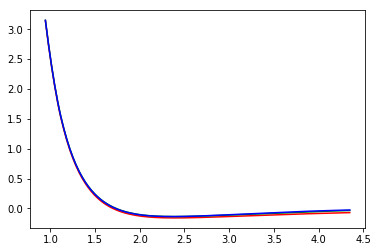

In [4]:
### take the derivative of the potential to get the negative of the force from RHF
RHF_Force = RHF_E_Spline.derivative() 

### negative of the force from MP2
MP2_Force = MP2_E_Spline.derivative()

### negative of the force from CCSD
CCSD_Force = CCSD_E_Spline.derivative()

### let's plot the forces for each level of theory!

### plot the forces... note we need to multiply by -1 since the spline
### derivative gave us the negative of the force!
plt.plot(r_fine, -1*RHF_Force(r_fine), 'red')
plt.plot(r_fine, -1*MP2_Force(r_fine), 'green')
plt.plot(r_fine, -1*CCSD_Force(r_fine), 'blue')
plt.show()

Next we will find where the minimum of the potential energy surfaces are and use that
to find the equilibrium bond length:

In [5]:
### Find Equilibrium Bond-Lengths for each level of theory
RHF_Req_idx = np.argmin(RHF_E_fine)
MP2_Req_idx = np.argmin(MP2_E_fine)
CCSD_Req_idx = np.argmin(CCSD_E_fine)

### find the value of the separation corresponding to that index
RHF_Req = r_fine[RHF_Req_idx]
MP2_Req = r_fine[MP2_Req_idx]
CCSD_Req = r_fine[CCSD_Req_idx]

### print equilibrium bond-lengths at each level of theory!
print(" Equilibrium bond length at RHF/cc-pVDZ level is ",RHF_Req, "atomic units")
print(" Equilibrium bond length at MP2/cc-pVDZ level is ",MP2_Req, "atomic units")
print(" Equilibrium bond lengthat CCSD/cc-pVDZ level is ",CCSD_Req, "atomic units")


 Equilibrium bond length at RHF/cc-pVDZ level is  1.6975235344966797 atomic units
 Equilibrium bond length at MP2/cc-pVDZ level is  1.7317209867864842 atomic units
 Equilibrium bond lengthat CCSD/cc-pVDZ level is  1.7317209867864842 atomic units


At this point, take a moment to compare your equilibrium bond length with other teams who have used different levels of theory to compute their potential energy surfaces.  Which equilibrium bond length should be most trustworthy?

You might have learned that the Harmonic Oscillator potential, which is a reasonable model for the vibrational motion of diatomic atomcs near their equilibrium bond length, is given by
\begin{equation}
V(r) = \frac{1}{2} k (r-r_{eq})^2 + V_0
\end{equation}
and that the vibrational frequency of the molecule within the Harmonic oscillator model is given by
\begin{equation}
\nu = \frac{1}{2\pi}\sqrt{\frac{k}{\mu}}
\end{equation}
where $\mu$ is the reduced mass of the molecule and $k$ is known as the force constant.  
We can estimate the force constant as
\begin{equation}
k = \frac{d^2}{dr^2} V(r_{eq}).
\end{equation}

Let's go ahead and get the force constants at each level of theory
and estimate the potential energy within the Harmonic approximation!

Hartree-Fock force constant is  0.720171712484416  atomic units
MP2 force constant is  0.6423033534589528  atomic units
CCSD force constant is  0.6393332662278279  atomic units


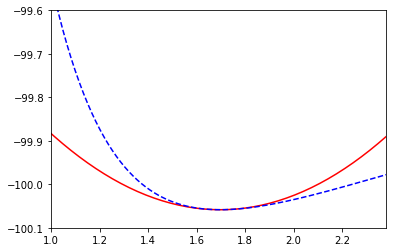

In [36]:
### get second derivative of potential energy curve... recall that we fit a spline to
### to the first derivative already and called that spline function X_Force, where
### X is either RHF, MP2, or CCSD

RHF_Curvature = RHF_Force.derivative()
MP2_Curvature = MP2_Force.derivative()
CCSD_Curvature = CCSD_Force.derivative()

### evaluate the second derivative at r_eq to get k
RHF_k = RHF_Curvature(RHF_Req)
MP2_k = MP2_Curvature(MP2_Req)
CCSD_k = CCSD_Curvature(CCSD_Req)

### Print force constants for each level of theory!
print("Hartree-Fock force constant is ",RHF_k," atomic units")
print("MP2 force constant is ",MP2_k," atomic units")
print("CCSD force constant is ",CCSD_k," atomic units")



And we can actually estimate the fundamental vibrational frequency of the molecule 
within this model using the force constant and the reduced mass of the molecule.

### Question 1:  What is the reduced mass of the HF molecule in atomic units?

### Question 2:  Use your spline fit to the PES of HF to estimate the vibrational frequency of HF.  Express your number in atomic units and also convert to a common spectroscopic unit system of your choosing (wavenumbers, nm, microns, Hertz, THz are all acceptable choices).

In [37]:
#HE = InterpolatedUnivariateSpline(r_fine, harm_pot, k=order)
#HF = -HE.derivative()
### define reduced mass of HF as m_H * m_H /(m_F + m_H) where mass is in atomic units (electron mass = 1)
m_F = 34883.
m_H = 1836.
mu = (m_F * m_H)/(m_F + m_H)

### compute the fundamental frequency at each level of theory
RHF_nu = 1/(np.pi*2) * np.sqrt(RHF_k/mu)
MP2_nu = 1/(np.pi*2) * np.sqrt(MP2_k/mu)
CCSD_nu = 1/(np.pi*2) * np.sqrt(CCSD_k/mu)

### print the values in atomic units!
print("Vibrational frequency of HF at the RHF/cc-pVDZ level is ",RHF_nu," atomic units")
print("Vibrational frequency of HF at the MP2/cc-pVDZ level is ",MP2_nu," atomic units")
print("Vibrational frequency of HF at the CCSD/cc-pVDZ level is ",CCSD_nu," atomic units")



Vibrational frequency of HF at the RHF/cc-pVDZ level is  0.0032340023504079155  atomic units
Vibrational frequency of HF at the MP2/cc-pVDZ level is  0.003054164301077867  atomic units
Vibrational frequency of HF at the CCSD/cc-pVDZ level is  0.003047094709146935  atomic units


### Question 3:  How does these vibrational frequencies compare to the experimental vibrational frequency of HF?

Next, we want to actually simulate the dynamics of the HF molecule on this _ab_ _initio_ potential energy surface.  To do so, we need to solve Newton's equations of motion subject to some initial condition for the position (separation) and momentum (in a relative sense) of the particles.  Newton's equations can be written
\begin{equation}
F(r) = \mu \frac{d^2}{dr^2}
\end{equation}
where $\mu$ is the reduced mass in atomic units and $F(r)$ is the Force vs separation in atomic units that was determined previously.  

### Question 4:  What will be the accelation of the bond stretch when H is separated by F by 3 atomic units?  You can express your acceleration in atomic units, also.



If the acceleration, position, and velocity of the bond stretch coordinate are known at some instant in 
time $t_i$, then the position and velocity can be estimated at some later time $t_{i+1} = t_i + \Delta t$:
\begin{equation}
r(t_i + \Delta t) = r(t_i) + v(t_i)\Delta t + \frac{1}{2}a(t_i)\Delta t^2
\end{equation}
and
\begin{equation}
v(t_i + \Delta t) = v(t_i) + \frac{1}{2} \left(a(t_i) + a(t_i + \Delta t)  \right) \Delta t.
\end{equation}
This prescription for updating the velocities and positions is known as the Velocity-Verlet algorithm.  
Note that we need to perform 2 force evaluations per Velocity-Verlet iteration: one corresponding
to position $r(t_i)$ to update the position, and then a second time at the updated position $r(t_i + \Delta t)$
to complete the velocity update.  

In [38]:
def Velocity_Verlet(r_curr, v_curr, mu, f_interp, dt):
    ### get acceleration at current time
    a_curr = -1*f_interp(r_curr)/mu
    
    ### use current acceleration and velocity to update position
    r_fut = r_curr + v_curr * dt + 0.5 * a_curr * dt**2
    
    ### use r_fut to get future acceleration a_fut
    a_fut = -1*f_interp(r_fut)/mu
    ### use current and future acceleration to get future velocity v_fut
    v_fut = v_curr + 0.5*(a_curr + a_fut) * dt
    
    result = [r_fut, v_fut]
    
    return result

### Validating Velocity-Verlet algorithm with the Harmonic Oscillator
Newton's equation of motion can be solved analytically for the Harmonic oscillator, and we can use this fact to validate our Velocity-Verlet algorithm (which provides an *approximate* solution to Newton's equation of motion for arbitrary potentials).  That is,
the vibrational motion of a diatomic subject to a Harmonic potential predicted 
by the Velocity-Verlet algorithm should closely match the analytical solution. If 
the diatomic is initially at its equilibrium bond length ($r(0) = r_{eq})$, then the bond-length at subsequent times can be written exactly as
\begin{equation}
r(t) = \sqrt{\frac{\mu}{k}} v_0 {\rm sin}\left(\sqrt{\frac{k}{\mu}} t\right) + r_{eq}.
\end{equation}


In [ ]:
### define harmonic potential for each level of theory
RHF_Harm_Pot = 0.5*RHF_k*(r_fine-RHF_Req)**2 + RHF_E_Spline(RHF_Req)
MP2_Harm_Pot = 0.5*MP2_k*(r_fine-MP2_Req)**2 + MP2_E_Spline(MP2_Req)
CCSD_Harm_Pot = 0.5*CCSD_k*(r_fine-CCSD_Req)**2 + CCSD_E_Spline(CCSD_Req)


### plot!
plt.plot(r_fine, RHF_Harm_Pot, 'red')
plt.plot(r_fine, RHF_E_fine, 'b--' )
#plt.plot(r_fine, MP2_Harm_Pot, 'green')
#plt.plot(r_fine, CCSD_Harm_Pot, 'blue')
plt.xlim(1.0, (1.69+0.69))
plt.ylim(-100.1,-99.6)
plt.show()

In [ ]:
def harmonic_position(om, Amp, phase, time):   
    return  Amp * np.sin( om * time + phase ) 

### how many updates do you want to perform?
N_updates = 50000

### establish time-step for integration to be 0.02 atomic units... this is about 0.0005 femtoseconds
### so total time is 200000*0.02 atomic units of time which is ~9.6e-13 s, or 960 fs
dt = 0.01

### harmonic results
hr_vs_t = np.zeros(N_updates)
hv_vs_t = np.zeros(N_updates)
ar_vs_t = np.zeros(N_updates)
t_array = np.zeros(N_updates)

### establish some constants!
### harmonic freq
om = np.sqrt(RHF_k/mu)
### initial displacement
x0 = 0.2
### amplitude for analytic solution
Amp = x0/(np.sin(np.pi/4))
### initial velocity
v0 = Amp * om * np.cos(np.pi/4)

hr_vs_t[0] = RHF_Req+x0
hv_vs_t[0] = v0

### Let's get the RHF Harmonic Force Spline
### use cubic spline interpolation
order = 3

### spline for RHF Energy
RHF_Harm_Pot_Spline = InterpolatedUnivariateSpline(r_fine, RHF_Harm_Pot, k=order)
RHF_Harm_Force = RHF_Harm_Pot_Spline.derivative()
### first Velocity Verlet update
result_array = Velocity_Verlet(hr_vs_t[0], hv_vs_t[0], mu, RHF_Harm_Force, dt)
#hresult_array = Velocity_Verlet(r_init, v_init, mu, HF, dt)

print(result_array)
#print(hresult_array)
ar_vs_t[0] = harmonic_position(om, Amp, np.pi/4, 0) + RHF_Req
### do the update N_update-1 more times
for i in range(1,N_updates):
    tmp = Velocity_Verlet(result_array[0], result_array[1], mu, RHF_Harm_Force, dt)
    result_array = tmp
    t_array[i] = dt*i
    hr_vs_t[i] = result_array[0]
    hv_vs_t[i] = result_array[1]
    ar_vs_t[i] = harmonic_position(om, Amp, np.pi/4, dt*i) + RHF_Req

plt.plot(t_array, hr_vs_t, 'red', t_array, ar_vs_t, 'b--')
plt.show()


In [ ]:
### how many updates do you want to perform?
N_updates = 200000

### establish time-step for integration to be 0.02 atomic units... this is about 0.0005 femtoseconds
### so total time is 200000*0.02 atomic units of time which is ~9.6e-13 s, or 960 fs
dt = 0.02

### Now use r_init and v_init and run velocity verlet update N_updates times, plot results
### these arrays will store the time, the position vs time, and the velocity vs time
r_vs_t = np.zeros(N_updates)
v_vs_t = np.zeros(N_updates)
t_array = np.zeros(N_updates)

### harmonic results
hr_vs_t = np.zeros(N_updates)
hv_vs_t = np.zeros(N_updates)


### first entry is the intial position and velocity
r_vs_t[0] = r_init
v_vs_t[0] = v_init

hr_vs_t[0] = r_init
hv_vs_t[0] = v_init

### first Velocity Verlet update
result_array = Velocity_Verlet(r_init, v_init, mu, RHF_Force, dt)
#hresult_array = Velocity_Verlet(r_init, v_init, mu, HF, dt)

print(result_array)
#print(hresult_array)

### do the update N_update-1 more times
for i in range(1,N_updates):
    tmp = Velocity_Verlet(result_array[0], result_array[1], mu, RHF_Force, dt)
    result_array = tmp
    t_array[i] = dt*i
    r_vs_t[i] = result_array[0]
    v_vs_t[i] = result_array[1]
    #tmp = Velocity_Verlet(hresult_array[0], hresult_array[1], mu, HF, dt)
    #hr_vs_t[i] = hresult_array[0]
    #hv_vs_t[i] = hresult_array[1]

### Plot the trajectory of bondlength vs time:
#plt.plot(t_array, r_vs_t, 'red', t_array, hr_vs_t, 'blue')
plt.plot(t_array, r_vs_t)
plt.show()

### plot the phase space trajectory of position vs momentum
#plt.plot(mu*v_vs_t, r_vs_t, 'blue', mu*hv_vs_t, hr_vs_t, 'purple')
#plt.show()

To be able to define the very first update, an initial position and velocity must be specified.  Typically, these are chosen at random from a sensible range of values.

### Question 5: What makes a "sensible range of values" for position and velocity?

In this case, we will initialize the position to be a random number between 1.0 and 4.0; for the velocity, we will use the fact that we can estimate the expectation value of kinetic energy for a very similar system (the Harmonic oscillator) in the ground state as follows:
\begin{equation}
\langle T \rangle = \frac{1}{2} E_g,
\end{equation}
where $E_g$ is the ground state of the Harmonic oscillator (this is making use of the Virial theorem).  We can easily
find the ground state energy in the Harmonic oscillator approximation of $HF$ using our frequency calculation described above as
\begin{equation}
E_g = \frac{1}{2} h \nu,
\end{equation}
which implies the kinetic energy expectation value is
\begin{equation}
\langle T \rangle = \frac{h}{8 \pi} \sqrt{\frac{k}{\mu}}.
\end{equation}
Since we can say classically that the kinetic energy is given by $T = \frac{1}{2}\mu v^2$, we can estimate the velocity of the bond stretch as follows:
\begin{equation}
v = \sqrt{\frac{2 \langle T \rangle}{\mu}} = \sqrt{ \frac{\hbar \sqrt{\frac{k}{\mu}}}{2\mu}}
\end{equation}
where we have simplified using the fact that $\hbar = \frac{h}{2\pi}$ ($\hbar$ has the value 1 in the atomic unit system we are using up to this point!).  We will assume that a reasonable
range of velocities spans plus or minus 3 times this "ground-state" velocity.


In [39]:
### define "ground-state" velocity for each level of theory
v_RHF = np.sqrt( np.sqrt(RHF_k/mu)/(2*mu))
v_MP2 = np.sqrt( np.sqrt(MP2_k/mu)/(2*mu))
v_CCSD = np.sqrt( np.sqrt(CCSD_k/mu)/(2*mu))


### get random position and velocity for RHF HF within a reasonable range
#r_init = np.random.uniform(0.75*RHF_Req,2*RHF_Req)
r_init = RHF_Req
v_init = np.random.uniform(-2*v_RHF,2*v_RHF)

### print initial position and velocity
print("Initial separation is ",r_init, "atomic units")
print("Initial velocity is   ",v_init, "atomic units")


### get initial force on the particle based on its separation
RHF_F_init = -1*RHF_Force(r_init)
print("Initial Force is ", RHF_F_init, "atomic units")


Initial separation is  1.6975235344966797 atomic units
Initial velocity is    -0.0013839204810472618 atomic units
Initial Force is  -0.0003233757202937039 atomic units


Now that we have our initial conditions chosen, our force as a function of separation known, and our Velocity Verlet function completed, we are ready to run our simulations!